In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
!ls /content/drive/MyDrive/allDatanew.csv

/content/drive/MyDrive/allDatanew.csv


Load necessary imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torch.utils.data import Subset
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn


cuda_enabled = torch.cuda.is_available()
# # Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CUDA_VISIBLE_DEVICES=0,1,2,3
cudnn.benchmark = True

from skimage import io, transform
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import glob
from __future__ import print_function, division
import datetime
import sys
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from ast import literal_eval

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
device

device(type='cuda')

In [5]:
!nvidia-smi

Mon May 16 19:50:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


#### Bidirectional Recurrent Neural Network

In [6]:
# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.is_training = False
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Dropout(p=0.5, inplace=False)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.linear = nn.Linear(self.hidden_size*2, self.num_classes)
        if cuda_enabled:
            self.lstm = self.lstm.cuda()
            self.fc = self.fc.cuda()
            self.linear = self.linear.cuda()
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        if cuda_enabled:
            h0 = h0.cuda()  # 2 for bidirection
            c0 = c0.cuda()
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode hidden state of last time step
        if self.is_training:
            out = self.fc(out[:, -1, :])
        else:
            out = out[:, -1, :]
        # out = F.log_softmax(self.linear(out), dim=1)
        return out

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample.

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




Eye Dataset

In [35]:
class EyeLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):#root_dir = img_dir
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)#same as image label

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        name = self.landmarks_frame.iloc[idx, 0]
        labels = np.zeros(8)
        for i in range(8):
            labels[i]=name
        labels = torch.Tensor(labels).long()
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        marks = []
        for mark in range(len(landmarks)):
            arr = literal_eval(landmarks[mark])[0]
            arr1 = []
            for i in range(len(arr)):
                for j in range(len(arr[i])):
                    arr1.append(arr[i][j])
            marks.append(np.array(arr1))                            
        marks = torch.Tensor(marks)
        
        sample = {'label': labels, 'marks': marks}
        if self.transform:
            sample = self.transform(sample)
        return sample

Body Dataset

In [15]:
class BodyLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):#root_dir = img_dir
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)#same as image label

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        name = self.landmarks_frame.iloc[idx, 0]
        labels = np.zeros(36)
        for i in range(36):
            labels[i]=name
        labels = torch.Tensor(labels).long()
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        marks = []
        for mark in range(len(landmarks)):
            arr=literal_eval(landmarks[mark])
            arr1=[]
            for i in range(len(arr)):
                arr1.append(float(arr[i]))
                           
            arr1 = np.array(arr1)
            marks.append(arr1)
                 
        marks = torch.Tensor(marks)
        
        sample = {'label': labels, 'marks': marks}
        if self.transform:
            sample = self.transform(sample)
        return sample

Load Eye Dataset

In [36]:
eyedataset = EyeLandmarksDataset(csv_file='/content/drive/MyDrive/allDatanew.csv')
eyedataset.__len__(), eyedataset.__getitem__(0)['label'].shape, eyedataset.__getitem__(0)['marks'].shape

(229, torch.Size([8]), torch.Size([511, 8]))

Load Body Dataset

In [17]:
bodydataset = BodyLandmarksDataset(csv_file='/content/drive/MyDrive/noBlanksnew.csv')
bodydataset.__len__(), bodydataset.__getitem__(0)['label'].shape, bodydataset.__getitem__(0)['marks'].shape

(217, torch.Size([36]), torch.Size([511, 36]))

In [18]:
bodydataset.__getitem__(100)['label'], bodydataset.__getitem__(100)['marks']

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([[834., 156.,  -1.,  ..., 156.,  -1.,  -1.],
         [806., 140.,  -1.,  ..., 156.,  -1.,  -1.],
         [806., 140.,  -1.,  ..., 156.,  -1.,  -1.],
         ...,
         [ -1.,  -1.,  -1.,  ...,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  ...,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  ...,  -1.,  -1.,  -1.]]))

In [37]:
eyedataset.__getitem__(228)['marks'][:5], eyedataset.__getitem__(228)['label']

(tensor([[ 42.,  56.,  52.,  52., 123.,  69.,  39.,  39.],
         [124.,  69.,  38.,  38.,  86., 144.,  57.,  57.],
         [122.,  65.,  43.,  43.,  81., 141.,  63.,  63.],
         [ 39.,  56.,  55.,  55., 122.,  62.,  49.,  49.],
         [ 34.,  57.,  54.,  54., 117.,  60.,  51.,  51.]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1]))

Divide Dataset for Training and Testing


In [20]:
def train_total_dataset(dataset, total_split=0.30): #Training set be 70% of the dataset
    train_idx, total_idx = train_test_split(list(range(len(dataset))), test_size=total_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['total_split'] = Subset(dataset, total_idx)
    return datasets

# hyperparams for the network
batch_size = 64

Make Eye NN Loders

In [38]:
print('Starting Eye NN dataset -------------------------------------')
eye_datasets = train_total_dataset(eyedataset)
eye_train = eye_datasets['train']
eye_test = eye_datasets['total_split']
# The original dataset is available in the Subset class
print(len(eye_datasets['train'].dataset), eye_datasets['train'].dataset)
print(len(eye_train), eye_train)
print(len(eye_test), eye_test)

print('Starting Eye NN loader -------------------------------------')
eye_train_loader = DataLoader(dataset=eye_train, batch_size=batch_size, shuffle=True)
eye_test_loader = DataLoader(dataset=eye_test, batch_size=batch_size, shuffle=False)
print(len(eye_train_loader), eye_train_loader)
print(len(eye_test_loader), eye_test_loader)
print('Finish  -------------------------------------')

Starting Eye NN dataset -------------------------------------
229 <__main__.EyeLandmarksDataset object at 0x7f546cc310d0>
160 <torch.utils.data.dataset.Subset object at 0x7f546ca31dd0>
69 <torch.utils.data.dataset.Subset object at 0x7f546ca31550>
Starting Eye NN loader -------------------------------------
3 <torch.utils.data.dataloader.DataLoader object at 0x7f546ca31f10>
2 <torch.utils.data.dataloader.DataLoader object at 0x7f546ca31f90>
Finish  -------------------------------------


Make Body NN Loders

In [22]:
print('Starting Body NN dataset -------------------------------------')
body_datasets = train_total_dataset(bodydataset)
body_train = body_datasets['train']
body_test = body_datasets['total_split']
# The original dataset is available in the Subset class
print(len(body_datasets['train'].dataset), body_datasets['train'].dataset)
print(len(body_train), body_train)
print(len(body_test), body_test)

print('Starting Body NN loader -------------------------------------')
body_train_loader = DataLoader(dataset=body_train, batch_size=batch_size, shuffle=True)
body_test_loader = DataLoader(dataset=body_test, batch_size=batch_size, shuffle=False)
print(len(body_train_loader), body_train_loader)
print(len(body_test_loader), body_test_loader)
print('Finish  -------------------------------------')

Starting Body NN dataset -------------------------------------
217 <__main__.BodyLandmarksDataset object at 0x7f546dfe5890>
151 <torch.utils.data.dataset.Subset object at 0x7f546cf3bed0>
66 <torch.utils.data.dataset.Subset object at 0x7f546cf23210>
Starting Body NN loader -------------------------------------
3 <torch.utils.data.dataloader.DataLoader object at 0x7f546cf230d0>
2 <torch.utils.data.dataloader.DataLoader object at 0x7f546cf23a50>
Finish  -------------------------------------


LSTM Init parameters

In [26]:
#Init NN
input_size = 1
sequence_length = 511
hidden_size = 128
num_layers = 2
num_classes = 2  # TODO: Determine this from the data
learning_rate = 0.0001
num_epochs = 300
epoch_loss = 5000000000.

Eye Tracking LSTM

In [39]:
# The network
eye_model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
eye_model.is_training = True

# Loss and optimizer
eye_criterion = nn.CrossEntropyLoss()
eye_optimizer = torch.optim.Adam(eye_model.parameters(), lr=learning_rate)

Body Tracking LSTM

In [30]:
# The network
body_model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
body_model.is_training = True

# Loss and optimizer
body_criterion = nn.CrossEntropyLoss()
body_optimizer = torch.optim.Adam(body_model.parameters(), lr=learning_rate)

Check loaders

In [43]:
for i, (sample) in enumerate(eye_train_loader):
    labels, marks = sample['label'], sample['marks']
    print(labels[0])
    print(marks[0][:5])
    break

for i, (sample) in enumerate(body_train_loader):
    labels, marks = sample['label'], sample['marks']
    print(labels[0])
    print(marks[0][:5])
    break

tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([[154.,  60.,  67.,  67.,  38.,  56.,  66.,  66.],
        [ 28.,  54.,  66.,  66., 143.,  62.,  63.,  63.],
        [ 36.,  55.,  59.,  59.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [46]:
#just for retesting purposes using only 2 epochs
num_epochs = 2
#For training purposes we used 300 epochs, we recommend using at least 100 epochs for good training results

Train Eye LSTM

In [47]:
eye_epochs = []
eye_losses = []
timing = dict()
timing['total_training'] = datetime.datetime.now()
for epoch in range(num_epochs):
    timing['training'] = datetime.datetime.now()
    loss_total = 0.
    iteration_count = 0.
    for i, sample in enumerate(eye_train):
        iteration_count += 1.
        labels, marks = sample['label'], sample['marks'] 
        marks = marks.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        if cuda_enabled:
            marks = marks.cuda()
            labels = labels.cuda()

        # Forward + Backward + Optimize
        eye_optimizer.zero_grad()
        outputs = eye_model(marks)

        loss = eye_criterion(outputs, labels)
        loss_total += loss.item()
        loss.backward()
        eye_optimizer.step()

        if (i + 1) % 10 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(eye_train) // batch_size, loss.item()))
    current_epoch_loss = loss_total / iteration_count
    print('Epoch %d; loss = %0.4f' % (epoch, current_epoch_loss))
    eye_epochs.append(epoch)
    eye_losses.append(current_epoch_loss)
    timing['training'] = datetime.datetime.now() - timing['training']
    print(timing['training'])
    epoch_loss = current_epoch_loss

timing['total_training'] = datetime.datetime.now() - timing['total_training']
print(timing['total_training'])


Epoch [1/2], Step [10/2], Loss: 0.7108
Epoch [1/2], Step [20/2], Loss: 0.7989
Epoch [1/2], Step [30/2], Loss: 0.6629
Epoch [1/2], Step [40/2], Loss: 0.5384
Epoch [1/2], Step [50/2], Loss: 0.5374
Epoch [1/2], Step [60/2], Loss: 0.6042
Epoch [1/2], Step [70/2], Loss: 0.5616
Epoch [1/2], Step [80/2], Loss: 0.6309
Epoch [1/2], Step [90/2], Loss: 0.6407
Epoch [1/2], Step [100/2], Loss: 0.6707
Epoch [1/2], Step [110/2], Loss: 0.8269
Epoch [1/2], Step [120/2], Loss: 0.7008
Epoch [1/2], Step [130/2], Loss: 0.6922
Epoch [1/2], Step [140/2], Loss: 0.7707
Epoch [1/2], Step [150/2], Loss: 0.5875
Epoch [1/2], Step [160/2], Loss: 0.5267
Epoch 0; loss = 0.6750
0:00:10.204529
Epoch [2/2], Step [10/2], Loss: 0.7155
Epoch [2/2], Step [20/2], Loss: 0.8112
Epoch [2/2], Step [30/2], Loss: 0.6520
Epoch [2/2], Step [40/2], Loss: 0.5347
Epoch [2/2], Step [50/2], Loss: 0.5338
Epoch [2/2], Step [60/2], Loss: 0.5996
Epoch [2/2], Step [70/2], Loss: 0.5568
Epoch [2/2], Step [80/2], Loss: 0.6185
Epoch [2/2], Step [

In [48]:
# Save the Model
torch.save(eye_model.state_dict(), 'ShouldIDrive_eye_tracking_colab1_retesting.pkl')

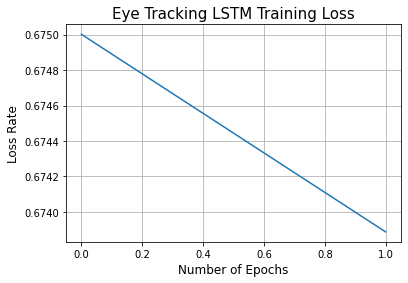

In [49]:
textfile = open("eyelosseslist.txt", "w")
for element in eye_losses:
  textfile.write(str(element) + "\n")
textfile.close()

plt.plot(eye_epochs, eye_losses)
plt.title('Eye Tracking LSTM Training Loss',fontsize=15)
plt.ylabel('Loss Rate',fontsize=12) 
plt.xlabel('Number of Epochs',fontsize=12) 
plt.grid(True) 
plt.savefig('eyelosscurve.png')
plt.show()

If you have previously trained the LSTM and have saved the model as a pickle file, then you can start loading the model here and testing :

Load Trained Eye Model

In [54]:
eye_model_path = '/content/ShouldIDrive_eye_tracking_colab1_retesting.pkl'

eye_model.load_state_dict(torch.load(eye_model_path))
eye_model.eval()

BiRNN(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

Test Eye LSTM

In [78]:
eye_model.is_training = False
timing = dict()
timing['testing'] = datetime.datetime.now()
print('Testing -----------------------------------------------')
correct = 0.0
for total, (sample) in enumerate(eye_test):
      labels, marks = sample['label'], sample['marks']
      marks = marks.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.to(device)
      outputs = eye_model(marks)
      _, predicted = torch.max(outputs.data, 1)
      if(predicted.__contains__(labels[0].item())): correct += 1.0

total += 1
print('Test Accuracy of {} model \n on the {} test videos: {} %'.format(eye_model_path, total, 100 * correct / total)) 
timing['testing'] = datetime.datetime.now() - timing['testing']
print(timing['testing'])

Testing -----------------------------------------------
Test Accuracy of /content/ShouldIDrive_eye_tracking_colab1_retesting.pkl model 
 on the 69 test videos: 0.0 %
0:00:02.712185


Train Body LSTM

In [67]:
body_epochs = []
body_losses = []
timing = dict()
timing['total_training'] = datetime.datetime.now()
for epoch in range(num_epochs):
    timing['training'] = datetime.datetime.now()
    loss_total = 0.
    iteration_count = 0.
    for i, sample in enumerate(body_train):
        iteration_count += 1.
        labels, marks = sample['label'], sample['marks'] 
        marks = marks.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        if cuda_enabled:
            marks = marks.cuda()
            labels = labels.cuda()

        # Forward + Backward + Optimize
        body_optimizer.zero_grad()
        outputs = body_model(marks)

        loss = body_criterion(outputs, labels)
        loss_total += loss.item()
        loss.backward()
        body_optimizer.step()

        if (i + 1) % 10 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(body_train) // batch_size, loss.item()))
    current_epoch_loss = loss_total / iteration_count
    print('Epoch %d; loss = %0.4f' % (epoch, current_epoch_loss))
    body_epochs.append(epoch)
    body_losses.append(current_epoch_loss)
    timing['training'] = datetime.datetime.now() - timing['training']
    print(timing['training'])
    epoch_loss = current_epoch_loss

timing['total_training'] = datetime.datetime.now() - timing['total_training']
print(timing['total_training'])


Epoch [1/2], Step [10/2], Loss: 0.7324
Epoch [1/2], Step [20/2], Loss: 0.7281
Epoch [1/2], Step [30/2], Loss: 0.7151
Epoch [1/2], Step [40/2], Loss: 0.6788
Epoch [1/2], Step [50/2], Loss: 0.7016
Epoch [1/2], Step [60/2], Loss: 0.6830
Epoch [1/2], Step [70/2], Loss: 0.6968
Epoch [1/2], Step [80/2], Loss: 0.6742
Epoch [1/2], Step [90/2], Loss: 0.6839
Epoch [1/2], Step [100/2], Loss: 0.6858
Epoch [1/2], Step [110/2], Loss: 0.6706
Epoch [1/2], Step [120/2], Loss: 0.7046
Epoch [1/2], Step [130/2], Loss: 0.7495
Epoch [1/2], Step [140/2], Loss: 0.6602
Epoch [1/2], Step [150/2], Loss: 0.6340
Epoch 0; loss = 0.6925
0:00:13.881717
Epoch [2/2], Step [10/2], Loss: 0.6535
Epoch [2/2], Step [20/2], Loss: 0.6690
Epoch [2/2], Step [30/2], Loss: 0.6424
Epoch [2/2], Step [40/2], Loss: 0.7529
Epoch [2/2], Step [50/2], Loss: 0.6350
Epoch [2/2], Step [60/2], Loss: 0.6049
Epoch [2/2], Step [70/2], Loss: 0.6370
Epoch [2/2], Step [80/2], Loss: 0.6068
Epoch [2/2], Step [90/2], Loss: 0.6280
Epoch [2/2], Step [1

In [68]:
# Save the Model
torch.save(body_model.state_dict(), 'ShouldIDrive_body_tracking_colab1_retesting.pkl')

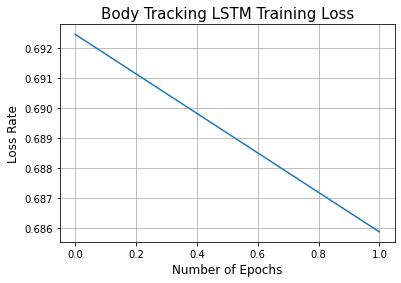

In [69]:
textfile = open("bodylosseslist.txt", "w")
for element in body_losses:
  textfile.write(str(element) + "\n")
textfile.close()

plt.plot(body_epochs, body_losses)
plt.title('Body Tracking LSTM Training Loss',fontsize=15)
plt.ylabel('Loss Rate',fontsize=12) 
plt.xlabel('Number of Epochs',fontsize=12) 
plt.grid(True) 
plt.savefig('bodylosscurve.png')
plt.show()

This next step can also work if you have access to an already saved trained model

Load Trained Body Model

In [70]:
body_model_path = '/content/ShouldIDrive_body_tracking_colab1_retesting.pkl'

body_model.load_state_dict(torch.load(body_model_path))
body_model.eval()

BiRNN(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

Test Body LSTM

In [85]:
body_model.is_training = False
timing = dict()
timing['testing'] = datetime.datetime.now()
print('Testing -----------------------------------------------')
correct = 0.0
for total, (sample) in enumerate(body_test):
      labels, marks = sample['label'], sample['marks']
      marks = marks.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.to(device)
      outputs = body_model(marks)
      _, predicted = torch.max(outputs.data, 1)
      if(predicted.__contains__(labels[0].item())): correct += 1.0

total += 1
print('Test Accuracy of {} model \n on the {} test videos: {} %'.format(body_model_path, total, 100 * correct / total)) 
timing['testing'] = datetime.datetime.now() - timing['testing']
print(timing['testing'])

Testing -----------------------------------------------
Test Accuracy of /content/ShouldIDrive_body_tracking_colab1_retesting.pkl model 
 on the 66 test videos: 0.0 %
0:00:03.968544


In [ ]:
# # Test the Model
with torch.no_grad():
  eye_model.is_training = False
  timing = dict()
  timing['testing'] = datetime.datetime.now()
  print('Testing -----------------------------------------------')
  correct = 0.0
  total = 0.0
  body_predicted_list = []
  body_label_list = []
  for i, sample in enumerate(eyedataset):#test_loader
      
      if(i ==228 ):
        labels, marks = sample['label'], sample['marks'] 
        ogmarks = marks

        marks = Variable(marks.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        # if cuda_enabled:
        #     marks = marks.cuda()
        print("Labels")
        print(labels)
        optimizer.zero_grad()
        outputs = eye_model(marks)
        # print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        print("Predicted labels")
        print(_)
        p_tot = 0.0
        for p, l in zip(_, labels):
          p = p.item()
          p_tot += p
        accuracy = p_tot/len(labels)
        print('Test Accuracy of the Eye Tracking model on the test video: \n {:.4f} %'.format(100 * accuracy)) 
        break

Testing -----------------------------------------------
Labels
tensor([1, 1, 1, 1])
Predicted labels
tensor([0.4248, 0.1220, 0.1220, 0.1220])
Test Accuracy of the Eye Tracking model on the test video: 
 19.7705 %


In [ ]:
eye_model.load_state_dict(torch.load(eye_model_path, map_location=torch.device('cpu')))
# print(eye_model.eval())

correct = 0.0
predicted_list = []
label_list = []
print('Testing -----------------------------------------------')

for total, (sample) in enumerate(eyedataset):
        # if(total==100):
        #   break
        if(total ==228 ):
          labels, marks = sample['label'], sample['marks']
          marks = marks.reshape(-1, sequence_length, input_size).to(device)
          labels = labels.to(device)
          print("Labels")
          print(labels)
          outputs = eye_model(marks)
          _, predicted = torch.max(outputs.data, 1)
          # print(labels[0][0].item())
          print("Predicted labels")
          print(predicted)
          for p, l in zip(predicted, labels):
            predicted_list.append(p.item())
            label_list.append(l.item())  

          accuracy = accuracy_score(label_list, predicted_list)

          print('Test Accuracy of the Eye Tracking model on the test video: \n {:.4f} %'.format(100 * accuracy)) 
          break
      # break

# print('Test Accuracy of {} model \n on the {} test videos: {} %'.format(eye_model_path, total, 100 * correct / total)) 

NameError: ignored

In [ ]:
# # Test the Model
eye_model.is_training = False
timing = dict()
timing['testing'] = datetime.datetime.now()
print('Testing -----------------------------------------------')
correct = 0.0
total = 0.0
eye_predicted_list = []
eye_label_list = []
auc = []
with torch.no_grad():
  for i, sample in enumerate(eye_test):#test_loader
      labels, marks = sample['label'], sample['marks'] 
      marks = marks.reshape(-1, sequence_length, input_size).to(device)
      # labels = labels.to(device)
      if cuda_enabled:
          marks = marks.cuda()

      outputs = eye_model(marks)
      outputs = torch.sigmoid(outputs)
      # print(outputs)
      y_pred_tag = torch.round(outputs)
      # print(y_pred_tag)
      print(labels[0])
      print(marks[0])
      eye_predicted_list.append(y_pred_tag.cpu().numpy())

    # outputs = F.log_softmax(eye_model.linear(outputs), dim=1)
    # _, pred = outputs.data.cpu().topk(1, dim=1)
    # # _, predicted = torch.max(outputs.data, 1)
    # # _, predicted = outputs.data
    # predicted = predicted.t()
    # y_pred = eye_model(marks)
    # # print(y_pred)
    # # print(labels)
    # accuracy=binary_acc(y_pred,labels).item()
    # test_acc = torch.sum(y_pred == labels)
    # print(accuracy)
    # auc.append(accuracy)

    # print(_)
    # print(predicted)
    # total += labels.size(0)
    # for p, l in zip(_, labels):
    #     # eye_p = int(np.round(p).item())
    #     # eye_l = l[0].item()
        
    #     eye_predicted_list.append(eye_p)
    #     eye_label_list.append(eye_l)
    #     if(eye_p == eye_l):
            # print(eye_p)
            # print(eye_l)
            # if(p.item()>0.95):
            #     print(p.item())
            #     print(eye_l)
            # print(sample['marks'][0][:5])
            # correct += 1.0
    # print(correct)
    # auc.append(100 * correct / total)

# print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total)) 
eye_predicted_list = [a.squeeze().tolist() for a in eye_predicted_list]
print(eye_predicted_list)
# print(classification_report(label_list, eye_predicted_list))
# print('Accuracy = %0.4f' % (accuracy_score(label_list, eye_predicted_list)))
timing['testing'] = datetime.datetime.now() - timing['testing']

NameError: ignored

In [ ]:
# # Test the Model
model.is_training = False
timing['testing'] = datetime.datetime.now()
print('Testing -----------------------------------------------')
correct = 0.0
total = 0.0
predicted_list = []
label_list = []
for mfcc, labels in test_loader:#test_loader
    mfcc = Variable(mfcc.view(-1, sequence_length, input_size))
    if cuda_enabled:
        mfcc = mfcc.cuda()

    outputs = rnn(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    for p, l in zip(predicted, labels):
        predicted_list.append(p)
        label_list.append(l)
        if p == l:
            correct += 1.0

timing['testing'] = datetime.datetime.now() - timing['testing']

In [ ]:
# Test the model
# with torch.no_grad():
#     model.is_training = False
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 97.39 %
